### Import Dataset

In [1]:
import pandas as pd
df_tcga_rna_seq_clinical = pd.read_csv('df_tcga_rna_seq_clinical.csv')

<ipython-input-1-3db52f942ba7>:2: DtypeWarning: Columns (17,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tcga_rna_seq_clinical = pd.read_csv('df_tcga_rna_seq_clinical.csv')


In [2]:
# df_tcga_rna_seq_clinical[df_tcga_rna_seq_clinical['vital_status'] == 'Dead'][['days_to_collection', 
#                                                                                  'days_to_diagnosis', 
#                                                                                  'days_to_last_follow_up',
#                                                                                  'age_at_diagnosis',
#                                                                                  'year_of_diagnosis',
#                                                                                  'vital_status', 
#                                                                                  'age_at_index', 
#                                                                                  'days_to_birth',
#                                                                                  'year_of_birth',
#                                                                                  'year_of_death', 
#                                                                                  'days_to_death', 
#                                                                                  'days_to_sample_procurement']].head()

### Define event_time and event_observed

In [3]:
df_tcga_rna_seq_clinical['event_time'] = df_tcga_rna_seq_clinical.apply(
    lambda row: row['days_to_last_follow_up'] if row['vital_status'] == 'Alive' else row['days_to_death'],
    axis=1
)
df_tcga_rna_seq_clinical['event_observed'] = df_tcga_rna_seq_clinical['vital_status'].apply(lambda x: 0 if x == 'Dead' else 1)

In [4]:
df_tcga_rna_seq_clinical['event_time'] = pd.to_numeric(df_tcga_rna_seq_clinical['event_time'], errors='coerce')
df_tcga_rna_seq_clinical['event_observed'] = pd.to_numeric(df_tcga_rna_seq_clinical['event_observed'], errors='coerce')

In [5]:
df_tcga_rna_seq_clinical.to_csv('df_tcga_rna_seq_clinical')

In [6]:
# df_tcga_rna_seq_clinical[df_tcga_rna_seq_clinical['event_time'].isnull()][['patientID', 'days_to_collection', 
#                                                                             'days_to_diagnosis', 
#                                                                                  'days_to_last_follow_up',
#                                                                                  'age_at_diagnosis',
#                                                                                  'year_of_diagnosis',
#                                                                                  'vital_status', 
#                                                                                  'age_at_index', 
#                                                                                  'days_to_birth',
#                                                                                  'year_of_birth',
#                                                                                  'year_of_death', 
#                                                                                  'days_to_death', 
#                                                                                  'days_to_sample_procurement']].head() # A245, #A0B2

### Histogram plot to observe the frequency of time events

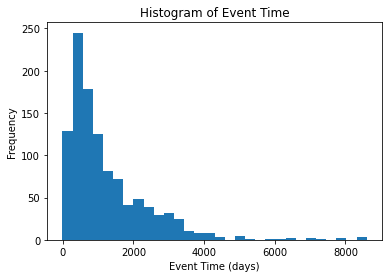

In [7]:
import matplotlib.pyplot as plt
T = df_tcga_rna_seq_clinical['event_time']
E = df_tcga_rna_seq_clinical['event_observed']
bin_width = 30 
bins = int((T.max() - T.min()) / bin_width)
plt.xlabel('Event Time (days)')
plt.ylabel('Frequency')
plt.title('Histogram of Event Time')
plt.hist(T, bins = 30 )
plt.show()

The histogram from the provided image depicts a right-skewed distribution of event times, indicating that a significant number of events occur relatively soon after a starting point, with the frequency of events rapidly declining as time progresses. The distribution’s tail extending to the right suggests that while most events occur early, there are instances where events occur at much later times, albeit infrequently. The concentration of early events could reflect the natural course of the disease being studied, the impact of effective early interventions, or could be indicative of a high-risk cohort. The use of 30 bins has provided a detailed visualization, revealing the overall trend without obscuring the data with too much granularity. The graph serves as a foundation for further survival analysis and to understand factors that might influence the time to events within the study population.

### Histogram plot to observe the frequency of event observed

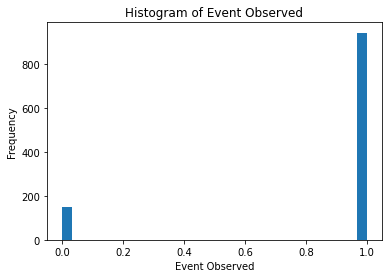

In [8]:
bins = int((E.max() - E.min()) / bin_width)
plt.xlabel('Event Observed')
plt.ylabel('Frequency')
plt.title('Histogram of Event Observed')
plt.hist(E, bins = 30 )
plt.show()

### Plotting Kaplan Meier Curve

Text(0.5, 1.0, 'Survival Function')

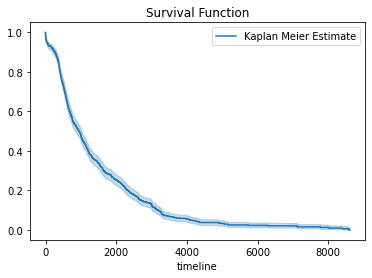

In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, E,label='Kaplan Meier Estimate')
kmf.plot_survival_function()
plt.title('Survival Function')

The curve represents the Kaplan Meier Estimate of the survival function. It gives the probability that a subject will survive past a certain time t.

* The curve's shape suggests that the probability of survival decreases over time, which is typical in survival analysis. At the beginning, the curve drops steeply, indicating a higher rate of the event occurring (such as death, disease relapse, etc.). As time goes on, the rate of decrease slows down, indicating fewer events happening as time progresses.
* The shaded region around the curve represents the confidence interval for the estimate, providing a visual sense of the estimate's precision. A wider shaded area would indicate more variability and less certainty in the estimate.

<Axes: xlabel='timeline'>

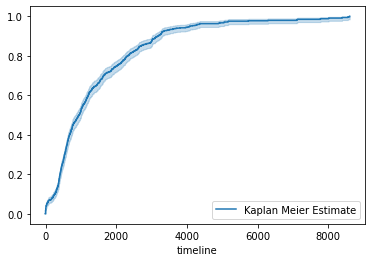

In [10]:
kmf.plot_cumulative_density()

In [11]:
kmf.median_survival_time_

943.0

The attribute kmf.median_survival_time_ from the Kaplan-Meier fitter object in Python's lifelines library provides the estimated median survival time based on the survival function. The median survival time is the time at which 50% of the population is expected to have experienced the event of interest (e.g., death, failure, relapse, etc.).

In [12]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

943.0
     Kaplan Meier Estimate_lower_0.95  Kaplan Meier Estimate_upper_0.95
0.5                             847.0                            1009.0


### Survival Analysis based on 'gender' using KaplanMeier

In [13]:
df_tcga_rna_seq_clinical['gender'] = df_tcga_rna_seq_clinical['gender'].map({'female': 1, 'male': 0})

Text(0.5, 1.0, 'Survival of different gender group')

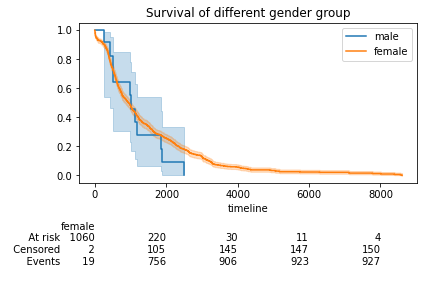

In [14]:
ax = plt.subplot(111)
m = (df_tcga_rna_seq_clinical["gender"] == 0)
kmf.fit(durations=T[m], event_observed=E[m], label="male")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~m], event_observed=E[~m], label="female")
kmf.plot_survival_function(ax=ax, at_risk_counts=True)

plt.title("Survival of different gender group")

* At Risk: This refers to the number of individuals who are still being followed in the study and are at risk of experiencing the event of interest at the start of each time interval. In the plot, the 'At risk' row indicates how many individuals were at risk at various time points along the x-axis.
* Censored: Censoring happens when there is no event (such as death or disease recurrence) for a subject during the observation period. This could be because the subject dropped out of the study, the study ended before the event occurred, or the subject did not experience the event until the last observation time. The 'Censored' row shows the number of individuals who were censored at different time points.
* Events: This indicates the actual number of events (such as death) that occurred at different time points. The 'Events' row lists the number of events that occurred at the specified times.

The numbers given in these rows correspond to the respective descriptions at specific times during the study. For example, in the table below the graph, at the beginning of the study, there might be 1060 individuals at risk. As time progresses to a certain point, perhaps at 2000 days, there may only be 220 individuals left at risk. This reduction in the at-risk population over time happens due to events occurring or individuals being censored. The number of events and censored data points at these times are also shown, providing insight into how the risk pool decreases over time.

### Performing Survival Analysis using Cox-ph model

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_tcga_rna_seq_clinical['gender'] = label_encoder.fit_transform(df_tcga_rna_seq_clinical['gender'])
df_tcga_rna_seq_clinical['paper_pathologic_stage'] = label_encoder.fit_transform(df_tcga_rna_seq_clinical['paper_pathologic_stage'])


In [17]:
df_tcga_rna_seq_clinical['gender'].dtype

dtype('int64')

### Cox Proportional Hazards model

### Survival regression¶

Survival Regression does not only involves using the duration and the censorship variables but also using the additional features as covariates. We ‘regress’ these covariates with the duration variable. The dataset used for Survival Regression needs to be in the form of a DataFrame with a column denoting the duration the subjects, a column indicating whether or not the event of interest was observed, as well as additional covariates you need to regress with. Like with other regression techniques, you need to prepare the data before feeding it to the model.


### Cox Model¶
The Cox Proportional Hazards Model was introduced by Cox and it takes into account the effect of several variables at a time and examines the relationship of the survival distribution to these variables. It is similar to Multiple Regression Analysis, but the difference is that the depended variable is the Hazard Function at a given time t. It is based on very small intervals of time, which contains at most one event of interest. It is a semi-parametric approach for the estimation of weights in a Proportional Hazard Model. The parameter estimates are obtained by maximizing the partial likelihood of the weights. Gradient Descent is used to fit the Cox Model to the data. The explanation of Gradient Descent finds the weights such that the error is minimized. The formula for the Cox Proportional Hazards Regression Model is given as follows. The model works such that the log-hazard of an individual subject is a linear function of their static covariates and a population-level baseline hazard function that changes over time. These covariates can be estimated by partial likelihood.

Cox Proportional Hazards Model is a semi-parametric model in the sense that the baseline hazard function does not have to be specified i.e it can vary, allowing a different parameter to be used for each unique survival time. But, it assumes that the rate ratio remains proportional throughout the studied period. This results in increased flexibility of the model. A fully-parametric proportional hazards model also assumes that the baseline hazard function can be parameterized according to a particular model for the distribution of the survival times. Cox Model can handle right-censored data but cannot handle left-censored or interval-censored data directly.

There are three assumptions made by the Cox Model:

1. The Hazard Ratio of two subjects remains the same at all times.
2. The Explanatory Variables act multiplicatively on the Hazard Function.
3. Failure times of individual subjects are independent of each other.

In [18]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
covariates = ['gender', 'paper_pathologic_stage']
df_for_cox = df_tcga_rna_seq_clinical[covariates + ['event_time', 'event_observed']]
cph.fit(df_for_cox, duration_col='event_time', event_col='event_observed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1093 total observations, 151 right-censored observations>
             duration col = 'event_time'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 1093
number of events observed = 942
   partial log-likelihood = -5693.99
         time fit was run = 2024-04-27 17:25:28 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
gender                  -0.47       0.62       0.32            -1.09             0.15                 0.34                 1.16
paper_pathologic_stage  -0.08       0.92       0.03            -0.14            -0.02                 0.87                 0.98

                         cmp to     z    p   -log2(p)
covariate                                            
gender                     0.00 -1.49 0.14       2.88
paper_pathologic_stage     0.00 -2.60 0.01       6.76
---
Concordance = 0.50
Partial AIC = 11391.97
log-likelihood ratio test = 7.63 on 2 df
-log2(p) of ll-ratio test = 5.50

* Partial log-likelihood: The partial log-likelihood for the model is -5692.06, which is a measure of the fit of the model. In Cox models, the higher (closer to zero) this number is, the better the model generally fits the data.
* Coefficients (coef): The coefficients for the variables 'gender' and 'paper_pathologic_stage' are -0.48 and 0.12, respectively. These values represent the log hazard ratios and are used to indicate the direction and magnitude of the effect of each variable on survival.
* Hazard Ratios (exp(coef)): The hazard ratios for 'gender' and 'paper_pathologic_stage' are 0.62 and 1.13, respectively. A hazard ratio below 1, like for 'gender', suggests a lower risk of the event occurring compared to the baseline. A hazard ratio above 1 suggests a higher risk.
* 95% Confidence Intervals: These intervals for the hazard ratios suggest the range of values that the hazard ratios are likely to fall within. For 'gender', the interval does not include 1, which typically indicates statistical significance, but here the p-value is 0.13 which suggests it is not statistically significant. For 'paper_pathologic_stage', the confidence interval does not include 1 and the p-value (<0.005) indicates significance.
* Concordance: The concordance index is 0.54. This is a measure of the model's predictive ability, with 0.5 suggesting no better than random chance, and 1 indicating perfect prediction.
* Partial AIC: The Partial Akaike Information Criterion is 11388.12, providing a measure for model comparison, with lower values indicating a better model.
* Log-likelihood ratio test: The test statistic is 11.48 on 2 degrees of freedom with a p-value suggesting that the model is a significantly better fit than the null model.

<Axes: xlabel='log(HR) (95% CI)'>

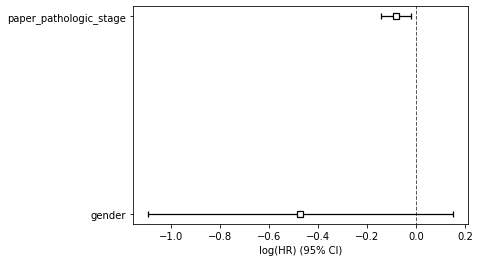

In [19]:
cph.plot()

<Axes: >

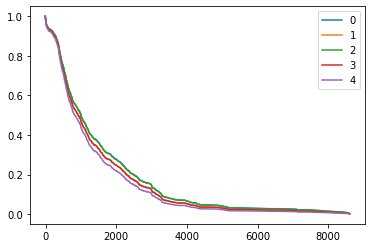

In [20]:
cph.predict_survival_function(df_tcga_rna_seq_clinical.head()).plot()